In [57]:
import os
import kagglehub
import pandas as pd
import seaborn as sns
import plotly.express as px
import optuna
import wandb
from optuna.pruners import MedianPruner
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn, optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
import gc
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import Subset
import tiktoken

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [59]:
torch.amp.autocast('cuda')   # FP16
torch.backends.cudnn.benchmark = True


In [60]:
data_path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")

print("Path to dataset files:", data_path)


Path to dataset files: /home/matan/.cache/kagglehub/datasets/datatattle/covid-19-nlp-text-classification/versions/1


In [61]:
train_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_train.csv"), encoding="latin1")
test_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_test.csv"), encoding="latin1")

In [62]:
print(train_df.shape, test_df.shape)

(41157, 6) (3798, 6)


In [63]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [64]:
train_df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [65]:
train_df['Sentiment'] = train_df['Sentiment'].astype('category')

Null count

In [66]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Seems that only location has null values. So, for visualizations involving location, we'll remove them.

Number of unique classes:

In [67]:
train_df['Sentiment'].value_counts().index

CategoricalIndex(['Positive', 'Negative', 'Neutral', 'Extremely Positive',
                  'Extremely Negative'],
                 categories=['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'], ordered=False, dtype='category', name='Sentiment')

In [68]:
df=train_df.copy()

In [69]:
df['text_length'] = df['OriginalTweet'].apply(lambda x: len(x.split()))
print(df['text_length'].describe())

count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: text_length, dtype: float64


### לא עובד לפי הסדר- המקרא לא נכון

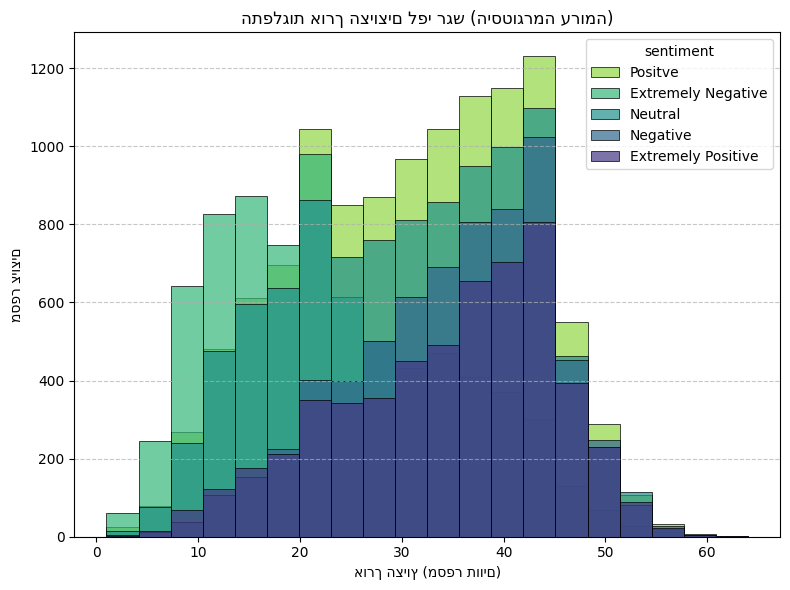

In [70]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x='text_length',
    hue='Sentiment',
    bins=20, # מספר סביבות ברירות המחדל של seaborn הוא לרוב סביר, אבל ניתן לשלוט בו
    multiple='layer', # אפשר גם 'dodge' (לצד זו), 'layer' (חופפות)
    stat='count', # מציג את הספירה בכל תא
    palette='viridis',
    alpha=0.7, # שקיפות
    edgecolor='black', # גבול סביב כל עמודה
    linewidth=0.5 # עובי הגבול
)

plt.title('התפלגות אורך הציוצים לפי רגש (היסטוגרמה ערומה)') # כותרת הגרף
plt.xlabel('אורך הציוץ (מספר תווים)') # תווית ציר X
plt.ylabel('מספר ציוצים') # תווית ציר Y
plt.grid(axis='y', linestyle='--', alpha=0.7) # הוספת קווי רשת לציר Y
plt.legend(title='sentiment', labels=['Positve','Extremely Negative','Neutral','Negative','Extremely Positive']) # הוספת כותרת ל-legend, אם כי הוא נוצר אוטומטית ע"י 'hue'.
plt.tight_layout() # התאמת הפריסה
plt.show()

In [71]:
sentiment_counts = train_df['Sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
fig = px.pie(sentiment_counts, values='Count', names='Sentiment', title='Distribution of Sentiments in Training Data', hole=0.4)
fig.show()

5 classes, seems quite balanced, if we see a bias towords the classes "positive" and "negative" we will have to consider weighted loss approch.
All in all, seems like the sentiment were not leaning toward negative emotions. on the contrary, there are more positive sentiment tweets than negative.

# Visualizations

## 1. Sentiment VS Geographical location

Clean dataframe for visualiations regarding location

In [72]:
SENTIMENT_TO_SCORE_MAPPING = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
    }

In [73]:
location_viz_df = train_df[~train_df["Location"].isna()]
location_viz_df["sentiment_score"] = location_viz_df["Sentiment"].map(SENTIMENT_TO_SCORE_MAPPING)

/tmp/ipykernel_2515/474962109.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
LOCATION_IQ_TOKEN = 'pk.141e2e5711ccfbe2bea40ef7e857c721'
SAMPLE_SIZE = 30 # because of a ratelimit to the API - maximum 5K / day

In [75]:
map_viz_df = location_viz_df.sample(SAMPLE_SIZE, random_state=23)

In [76]:
'''
import requests
import time
from tqdm import tqdm

def geocode_locationiq(location):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": LOCATION_IQ_TOKEN,
        "q": location,
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if isinstance(data, list) and data:
            return float(data[0]['lat']), float(data[0]['lon'])
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None, None

# Apply with a delay to avoid rate limits (optional, but safe)
results = []
for loc in tqdm(map_viz_df['Location']):
    lat, lon = geocode_locationiq(loc)
    results.append((lat, lon))
    time.sleep(0.5)  # Optional throttle (LocationIQ free tier = 2 req/sec)

# Split the results into new columns
map_viz_df[['latitude', 'longitude']] = pd.DataFrame(results, index=map_viz_df.index)
'''


'\nimport requests\nimport time\nfrom tqdm import tqdm\n\ndef geocode_locationiq(location):\n    url = "https://us1.locationiq.com/v1/search.php"\n    params = {\n        "key": LOCATION_IQ_TOKEN,\n        "q": location,\n        "format": "json"\n    }\n    try:\n        response = requests.get(url, params=params)\n        response.raise_for_status()\n        data = response.json()\n        if isinstance(data, list) and data:\n            return float(data[0][\'lat\']), float(data[0][\'lon\'])\n        else:\n            return None, None\n    except Exception as e:\n        print(f"Error geocoding {location}: {e}")\n        return None, None\n\n# Apply with a delay to avoid rate limits (optional, but safe)\nresults = []\nfor loc in tqdm(map_viz_df[\'Location\']):\n    lat, lon = geocode_locationiq(loc)\n    results.append((lat, lon))\n    time.sleep(0.5)  # Optional throttle (LocationIQ free tier = 2 req/sec)\n\n# Split the results into new columns\nmap_viz_df[[\'latitude\', \'longit

In [77]:
'''
agg_df = map_viz_df.groupby(['latitude', 'longitude'], as_index=False)['sentiment_score'].sum()
fig = px.density_mapbox(
    agg_df,
    lat="latitude",
    lon="longitude",
    z="sentiment_score",
    radius=25,
    center={"lat": 30, "lon": 0},
    zoom=1,
    mapbox_style="carto-positron"
)
fig.show()
'''

'\nagg_df = map_viz_df.groupby([\'latitude\', \'longitude\'], as_index=False)[\'sentiment_score\'].sum()\nfig = px.density_mapbox(\n    agg_df,\n    lat="latitude",\n    lon="longitude",\n    z="sentiment_score",\n    radius=25,\n    center={"lat": 30, "lon": 0},\n    zoom=1,\n    mapbox_style="carto-positron"\n)\nfig.show()\n'

## 2. Sentiment accross dates:
Total sentiment score per day

In [78]:
timeline_sentiment_df = train_df.copy()
timeline_sentiment_df = timeline_sentiment_df[["TweetAt", "Sentiment"]]

In [79]:
timeline_sentiment_df['TweetAt'] = pd.to_datetime(timeline_sentiment_df['TweetAt'], format='%d-%m-%Y')
heatmap_data = (
    timeline_sentiment_df.groupby([timeline_sentiment_df['TweetAt'], 'Sentiment'])
    .size()
    .reset_index(name='count')
)

# Pivot to matrix format for heatmap
heatmap_pivot = heatmap_data.pivot(index='Sentiment', columns='TweetAt', values='count').fillna(0)

heatmap_pivot = heatmap_pivot.loc[
    sorted(heatmap_pivot.index, key=lambda s: SENTIMENT_TO_SCORE_MAPPING[s])
]

# Plot heatmap
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Date", y="Sentiment Score", color="Tweet Count"),
    x=[col.strftime('%Y-%m-%d') for col in heatmap_pivot.columns],
    y=heatmap_pivot.index,
    color_continuous_scale='YlOrRd',
    aspect='auto'
)

fig.update_layout(
    title="Sentiment Frequency Over Time",
    xaxis_title="Date",
    yaxis_title="Sentiment",
    height=400
)
fig.show()

/tmp/ipykernel_2515/504013859.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## 3. Word-cloud per Sentiment

In [80]:
word_cloud_df = train_df[["OriginalTweet", "Sentiment"]]

In [81]:
word_cloud_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


/tmp/ipykernel_2515/4293034084.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_2515/4293034084.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



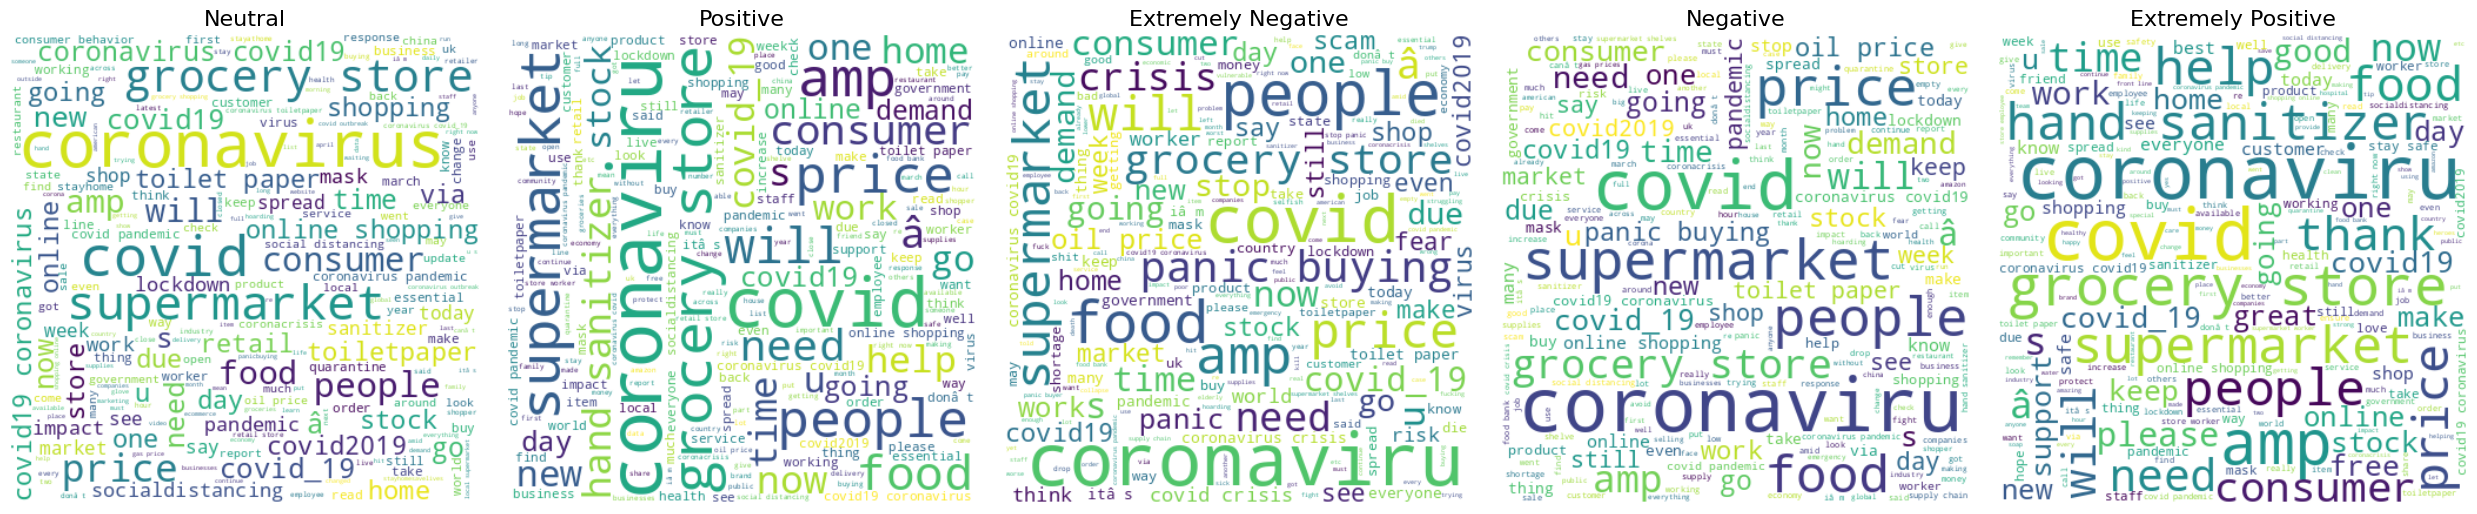

In [82]:

# lowercasing and basic cleaning
word_cloud_df['clean_text'] = word_cloud_df['OriginalTweet'].str.lower()

# Unique sentiments
sentiments = word_cloud_df['Sentiment'].unique()
to_remove = "http"

def delete_words_with_http(text, to_remove):

    if not isinstance(text, str):
        return text

    words = text.split() #

    kept_words = [word for word in words if to_remove not in word]

    return ' '.join(kept_words) #

word_cloud_df['clean_text'] = word_cloud_df['clean_text'].apply(lambda x: delete_words_with_http(x, to_remove))

# Plot word clouds
fig, axs = plt.subplots(1, len(sentiments), figsize=(5 * len(sentiments), 5))

if len(sentiments) == 1:
    axs = [axs]  # make iterable

for i, sentiment in enumerate(sentiments):
    text_blob = " ".join(word_cloud_df[word_cloud_df['Sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='viridis').generate(text_blob)

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(sentiment, fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [83]:
cleaned_df = word_cloud_df[['clean_text', 'Sentiment']].copy()
cleaned_df.head()

,clean_text,Sentiment
0,@menyrbie @phil_gahan @chrisitv and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia: woolworths to give elde...,Positive
3,my food stock is not the only one which is emp...,Positive
4,"me, ready to go at supermarket during the #cov...",Extremely Negative


The word cloud **did not show** any substantial differances between the topics of tweets under all sentiment categories

In [84]:
df_temp_indexed = train_df.copy()
df_temp_indexed.sample(8)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
18948,22747,67699,NaN,24-03-2020,From soaring food prices to millions trapped i...,Extremely Negative
3685,7484,52436,NaN,18-03-2020,Release update information. #FF7R https://t.co...,Neutral
39686,43485,88437,NaN,13-04-2020,Because We Care Contact us to buy Certified Ma...,Positive
22792,26591,71543,"Kanpur, UP India",25-03-2020,@Mohdati96271444 @AnnuTandonUnnao @maharaj_sak...,Negative
2798,6597,51549,Belgique,18-03-2020,And outside of the other grocery store 3 block...,Negative
36745,40544,85496,NaN,10-04-2020,New beat out on Youtube????\r\r\n*isolation* B...,Negative
40662,44461,89413,NaN,13-04-2020,My online shopping is getting out of control.....,Neutral
10051,13850,58802,Earth,20-03-2020,Suppliers of paracetamol are increasing their ...,Neutral


In [85]:
df_temp_indexed['TweetAt'] = pd.to_datetime(df_temp_indexed['TweetAt'])

df_dt_indexed = df_temp_indexed.copy().set_index('TweetAt')

# המרת סנטימנט לערך מספרי לצורך חישוב ממוצע
sentiment_map = {'Extremely Positive': 2, 'Positive': 1, 'Neutral': 0, 'Negative': -1, 'Extremely Negative': -2}
df_dt_indexed['Sentiment'] = df_dt_indexed['Sentiment'].map(sentiment_map)

df_dt_indexed.head()


/tmp/ipykernel_2515/3638697163.py:1: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,UserName,ScreenName,Location,OriginalTweet,Sentiment
TweetAt,,,,,
2020-03-16,3799,48751,London,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
2020-03-16,3800,48752,UK,advice Talk to your neighbours family to excha...,1
2020-03-16,3801,48753,Vagabonds,Coronavirus Australia: Woolworths to give elde...,1
2020-03-16,3802,48754,NaN,My food stock is not the only one which is emp...,1
2020-03-16,3803,48755,NaN,"Me, ready to go at supermarket during the #COV...",-2
